Device: cpu

Imagen elegida al azar:
pruebas\ig2.jpg
Recorte guardado en temp_recortes/recorte.jpg (confianza 0.90)
Predicción: 83.31 / 100 (sin nota real en CSV)


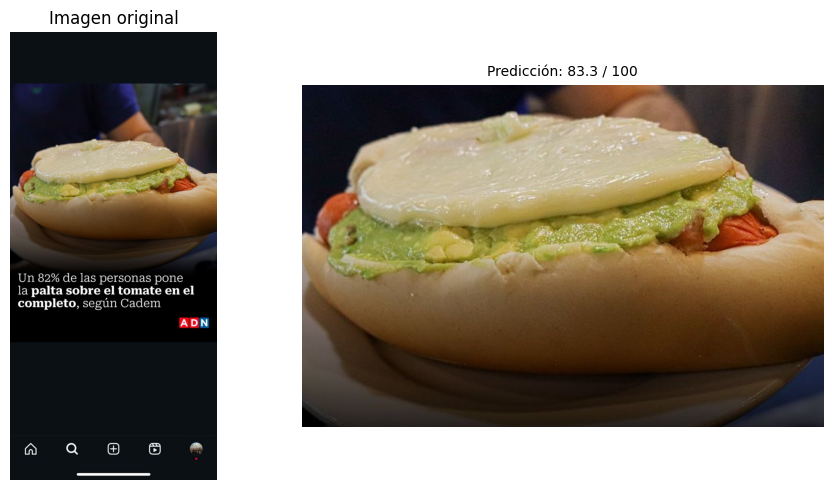

In [22]:
import os, random, cv2, math, torch, ast, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
from torchvision import transforms
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
import torch.nn as nn

BEST_PT = r"..\Detector completos\detector_completos\rf_completos\weights\best.pt" 
CROP_DIR = r"..\completos_regresion\v1 - Regresión simple\dataset\crops"
MERGED_CSV_PATH = r"..\completos_regresion\v1 - Regresión simple\dataset_regresion_extendido.csv"
IMG_SIZE = 224

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

detector = YOLO(BEST_PT)

weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
_mean, _std = weights.transforms().mean, weights.transforms().std
inference_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=_mean, std=_std),
])

model = mobilenet_v3_small(weights=weights)
in_f = model.classifier[3].in_features
model.classifier[3] = nn.Sequential(nn.Linear(in_f, 1), nn.Sigmoid())
model = model.to(device)
model.load_state_dict(torch.load(r"..\completos_regresion\v1 - Regresión simple\checkpoints\best_model.pth", map_location=device))
model.eval()

merged = pd.read_csv(MERGED_CSV_PATH)
if "score_clean" not in merged.columns:
    def clean_score_cell(x):
        try:
            if isinstance(x, str):
                data = ast.literal_eval(x)
                if isinstance(data, list) and data and isinstance(data[0], dict) and "number" in data[0]:
                    return float(data[0]["number"])
                return float(x)
            return float(x)
        except Exception:
            return None
    merged["score_clean"] = merged["score"].apply(clean_score_cell)
merged["img_path_norm"] = merged["img_path"].astype(str).apply(lambda x: x.replace("\\", "/"))

def detectar_y_recortar(imagen_path, conf_minima=0.5, clase_objetivo=0):
    """
    Usa el detector YOLO para extraer el recorte del completo más confiable.
    Retorna el path del recorte guardado (recorte.jpg).
    """
    img = cv2.imread(imagen_path)
    resultados = detector.predict(imagen_path, conf=conf_minima, verbose=False)

    mejor_box = None
    mejor_conf = 0.0
    for r in resultados:
        for box in r.boxes:
            if int(box.cls[0]) == clase_objetivo and box.conf[0] >= conf_minima:
                conf = float(box.conf[0])
                if conf > mejor_conf:
                    mejor_conf = conf
                    mejor_box = box.xyxy[0]

    if mejor_box is None:
        raise ValueError("No se detectó ningún completo en la imagen.")

    x1, y1, x2, y2 = map(int, mejor_box)
    recorte = img[y1:y2, x1:x2]

    os.makedirs("temp_recortes", exist_ok=True)
    crop_path = "temp_recortes/recorte.jpg"
    cv2.imwrite(crop_path, recorte)

    print(f"Recorte guardado en {crop_path} (confianza {mejor_conf:.2f})")
    return crop_path

def predecir_y_mostrar_con_real(ruta_imagen_original, split="test"):
    """
    Detecta el crop con YOLO, predice nota con MobileNet y muestra ambas imágenes.
    """
    # Detectar y recortar
    crop_path = detectar_y_recortar(ruta_imagen_original, conf_minima=0.4)
    img_original = Image.open(ruta_imagen_original).convert("RGB")
    img_crop = Image.open(crop_path).convert("RGB")

    # Inferencia con el modelo de regresión
    img_t = inference_tfms(img_crop).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img_t).cpu().numpy().flatten()[0] * 100.0

    ruta_norm = ruta_imagen_original.replace("\\", "/")
    match = merged[merged["img_path_norm"].str.endswith(os.path.basename(ruta_norm), na=False)]
    real = float(match.iloc[0]["score_clean"]) if len(match) > 0 else None

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img_original)
    axes[0].axis("off")
    axes[0].set_title("Imagen original")

    axes[1].imshow(img_crop)
    axes[1].axis("off")
    if real is not None:
        delta = abs(pred - real)
        axes[1].set_title(f"Crop evaluado\nReal: {real:.1f} | Pred: {pred:.1f}\nΔ={delta:.1f}", fontsize=10)
        print(f"Predicción: {pred:.2f} / 100  |  Real: {real:.2f}  |  Δ={delta:.2f}")
    else:
        axes[1].set_title(f"Predicción: {pred:.1f} / 100", fontsize=10)
        print(f"Predicción: {pred:.2f} / 100 (sin nota real en CSV)")

    plt.tight_layout()
    plt.show()

    return pred, real, crop_path

#carpeta = r"..\Detector completos\Dataset-Comida-Chilena-1\test\images"
carpeta = r"pruebas"

imagenes = glob.glob(os.path.join(carpeta, "*.jpg"))
ruta_aleatoria = random.choice(imagenes)

print(f"\nImagen elegida al azar:\n{ruta_aleatoria}")
pred, real, crop_path = predecir_y_mostrar_con_real(ruta_aleatoria, split="test")
